Reference to this excellent notebook:

https://www.kaggle.com/jagadish13/osic-baseline-elasticnet-eda

I highly recommand read it



## Load Libraries


In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

## Useful functions

In [2]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================

In [3]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"


## Read and load data

In [4]:
train = pd.read_csv(f"{ROOT}/train.csv")
train.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
test = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(test.drop('Weeks', axis=1), on="Patient")

add infos


In [5]:
## Add reference to the concatenated data
train['WHERE'] = 'train'
test['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = train.append([test, sub])

## Add Variables

In [6]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [7]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [8]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [9]:
from sklearn.preprocessing import LabelEncoder
lb =LabelEncoder()
data["Sex"] = lb.fit_transform(data["Sex"])

In [10]:
FE = []


data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['Sex','age','percent','week','BASE']

## Use k-means Segmentation to create a cluster variable

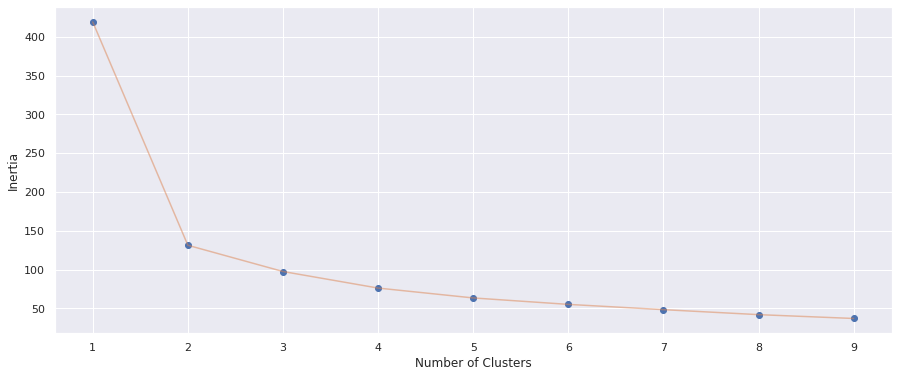

In [11]:


from sklearn.preprocessing import StandardScaler
std = StandardScaler()

features_scaled  =data[["age","percent",'Sex',"BASE"]]

from sklearn.cluster import DBSCAN, KMeans
## all data normalized
inertia = []
for n in range(1 , 10):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 100 ,max_iter=3000, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(features_scaled)
    inertia.append(algorithm.inertia_)
sns.set()
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 10) , inertia , 'o')
plt.plot(np.arange(1 , 10) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

## Silhouette Score

In [12]:
range_n_clusters = [2,3,4,5,6,7,8,9]
from sklearn.metrics import silhouette_score

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=90)
    kmeans.fit(features_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))



For n_clusters=2, the silhouette score is 0.7322953019957463
For n_clusters=3, the silhouette score is 0.4423861814882293
For n_clusters=4, the silhouette score is 0.4633062382406983
For n_clusters=5, the silhouette score is 0.4287799797179187
For n_clusters=6, the silhouette score is 0.3679811165976204
For n_clusters=7, the silhouette score is 0.3726090657288234
For n_clusters=8, the silhouette score is 0.3901200252727417
For n_clusters=9, the silhouette score is 0.40456768136677496


In [13]:
kmeans = KMeans(n_clusters=2, max_iter=3000)
kmeans.fit(features_scaled)
    

features_scaled["Cluster_Id"] =kmeans.labels_
features_scaled["FVC"] =data["FVC"]

## 3-D Visualisation

In [14]:
import plotly.express as px
fig = px.scatter_3d(features_scaled, x='percent', y='FVC', z='BASE',
              color='Cluster_Id')
fig.show()

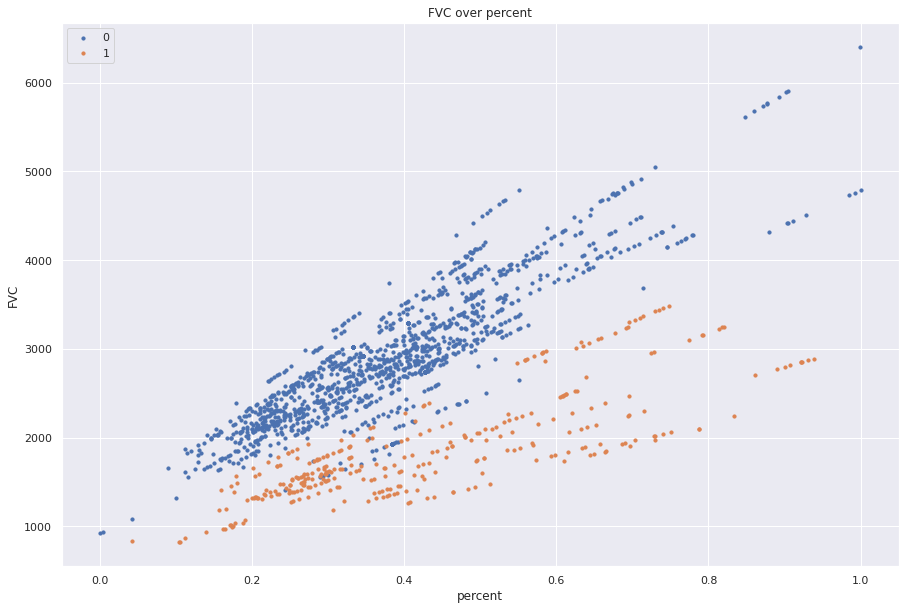

In [15]:
plt.figure(1 , figsize = (15 , 10))
for cluster in [0,1]:
    plt.scatter(x = 'percent' , y = 'FVC' , data = features_scaled[features_scaled['Cluster_Id'] == cluster] ,
                s = 10 , alpha = 1 , label = cluster)
plt.xlabel('percent'), plt.ylabel('FVC') 
plt.title('FVC over percent')
plt.legend()
plt.show()

In [16]:
algorithm = (KMeans(n_clusters =2,init='k-means++', n_init = 10 ,max_iter=10000, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(features_scaled)
data['Cluster_Id'] = algorithm.labels_

del features_scaled

In [17]:
## Dummy SmokingStatus

COLS = ['SmokingStatus']
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)



In [18]:
data = pd.get_dummies(data,columns=["Cluster_Id"])
for col in ("Cluster_Id_0","Cluster_Id_1"):
    data[col] = data[col].astype(int)
    
FE+=["Cluster_Id_0","Cluster_Id_1"]

## DBSCAN clustering

In [19]:
from sklearn import metrics
#varaible1 = std.fit_transform(data["FVC"])
features_scaled  =data[["min_FVC","percent","BASE","age"]]


## all data normalized
inertia = []

algorithm = (DBSCAN(eps=0.6, metric='euclidean',
                        metric_params=None, algorithm="auto", leaf_size=20, p=None, n_jobs=None))
algorithm.fit(features_scaled)
labels = algorithm.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[algorithm.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)# Printing the number of clusters and number of noise points (outliers)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)# Evaluating the quality of clusters
s = metrics.silhouette_score(features_scaled, algorithm.labels_)
print(f"Silhouette Coefficient for the  Dataset Clusters: {s:.2f}")

Estimated number of clusters: 168
Estimated number of noise points: 0
Silhouette Coefficient for the  Dataset Clusters: 0.99


In [20]:
algorithm = (DBSCAN(eps=0.5, min_samples=1, metric='euclidean',
                        metric_params=None, algorithm="auto", leaf_size=20, p=None, n_jobs=None))
algorithm.fit(features_scaled)
labels = algorithm.labels_

In [21]:
data['DBSCAN_CLUSTER'] = algorithm.labels_

for mod in data["DBSCAN_CLUSTER"].unique():
    FE.append(mod)
    data[mod] = (data["DBSCAN_CLUSTER"] == mod).astype(int)


In [22]:
## Resplit the data
train = data.loc[data.WHERE=='train']
test = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [23]:
y = train['FVC'].values
z = train[FE].values
ze = sub[FE].values
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

## Modeling

In [24]:
from tensorflow.keras import layers
from keras import regularizers

import keras
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#

def make_model(learning_rate):
    z = L.Input((178,), name="Patient")


    x = L.Dense(200, activation="relu",use_bias=True,kernel_regularizer=regularizers.l2(1e-7),
               bias_regularizer=regularizers.l2(1e-7),
               activity_regularizer=regularizers.l1(1e-7))(z)   
    keras.layers.Dropout(0.1)


    x = L.Dense(100, activation="relu",use_bias=True,kernel_regularizer=regularizers.l2(1e-7),
               bias_regularizer=regularizers.l2(1e-7),
               activity_regularizer=regularizers.l1(1e-7))(x)   
    keras.layers.Dropout(0.1)

  
    x = L.Dense(10, activation="relu",use_bias=True)(x)   
    keras.layers.Dropout(0.1)


    p1 = L.Dense(3, activation="linear", name="p1",use_bias=True)(x)
    p2 = L.Dense(3, activation="relu", name="p2",use_bias=True)(x)




    
    
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

''' x = L.Dense(90, activation="tanh", name="d2v",use_bias=True)(x)
    x = L.Dense(45, activation="tanh", name="d2f2",use_bias=True)(x)
    x = L.Dense(22, activation="tanh", name="d2dfx",use_bias=True)(x)
    x = L.Dense(10, activation="tanh", name="d4df5",use_bias=True)(x) ''' 

'''kernel_regularizer=regularizers.l2(1e-7),
               bias_regularizer=regularizers.l2(1e-7),
               activity_regularizer=regularizers.l1(1e-7)'''

'kernel_regularizer=regularizers.l2(1e-7),\n               bias_regularizer=regularizers.l2(1e-7),\n               activity_regularizer=regularizers.l1(1e-7)'

## Callbacks

In [25]:
## EarlyStopping
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15) 

## Keras API : Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates.
               #This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs,the learning rate is reduced.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0.0001
)

## Tensorboard
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")




In [26]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)
cnt = 0
BATCH_SIZE = 16
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(learning_rate=0.04)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=1000, 
            validation_data=(z[val_idx], y[val_idx]),callbacks=[es_callback,reduce_lr], verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [19.118013381958008, 5.681761264801025]
val [102.64090728759766, 8.71123218536377]
predict val...
predict test...
FOLD 2
train [20.32806396484375, 5.74790096282959]
val [95.52394104003906, 8.089376449584961]
predict val...
predict test...
FOLD 3
train [21.36916732788086, 5.777869701385498]
val [122.54689025878906, 8.912927627563477]
predict val...
predict test...
FOLD 4
train [20.70366668701172, 5.774441719055176]
val [107.52088165283203, 8.92888069152832]
predict val...
predict test...
FOLD 5
train [14.827981948852539, 5.4289703369140625]
val [71.53636169433594, 8.249433517456055]
predict val...
predict test...


In [27]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

261.07476802664394 89.93350949365076


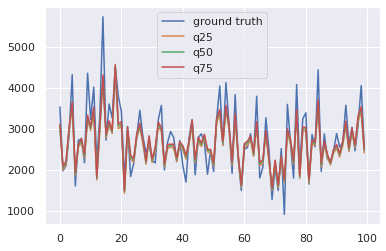

In [28]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

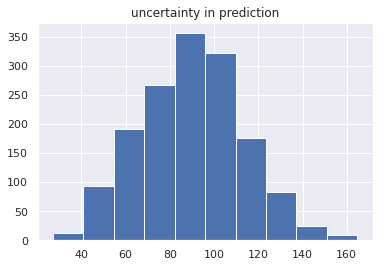

In [29]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [30]:
sub['FVC1'] = 0.996  * pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [31]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [32]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [33]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,2880.553764,100.286865,2880.553764,100.286865
1541,ID00419637202311204720264_-11,2878.709973,100.225586,2878.709973,100.225586
1542,ID00419637202311204720264_-10,2876.872990,100.164673,2876.872990,100.164673
1543,ID00419637202311204720264_-9,2875.035885,100.103638,2875.035885,100.103638
1544,ID00419637202311204720264_-8,2873.198903,100.042786,2873.198903,100.042786


In [34]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [35]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)